# Force-Torque Simulation Project

This notebook explores the simulation and analysis of force-torque measurements with an F/T sensor.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
class SimFTSensor:
    
    def __init__(self, position=(6.0, -7.0, -0.8), noise_level=0.01):
        self.position = np.array(position, dtype=float)
        self.noise_level = float(noise_level)

    def measure(self, force, application_point):
        force = np.array(force, dtype=float)
        application_point = np.array(application_point, dtype=float)
        r = (application_point - self.position) / 100.0  # Convert cm to m
        torque = np.cross(r, force)

        measurement = np.concatenate([force, torque])
        noise = np.random.normal(0.0, self.noise_level, 6)
        noisy_measurement = measurement + noise * np.abs(measurement)

        return noisy_measurement
    
    def estimate_contact_point_pinv(self, measurement, use_plane_constraint=True):
        force = measurement[:3]
        moment = measurement[3:]

        S_f_ext = np.array([
            [0, -force[2], force[1]],
            [force[2], 0, -force[0]],
            [-force[1], force[0], 0]
        ])

        S_f_ext_pinv = np.linalg.pinv(-S_f_ext)

        p_c_d = S_f_ext_pinv @ moment

        # Convert to cm and add sensor position
        unconstrained_point = (p_c_d * 100.0) + self.position

        if not use_plane_constraint:
            return unconstrained_point

        # Check if force is parallel to XY plane (i.e., force[2] ≈ 0)
        if abs(force[2]) < 1e-6:
            print("Warning: Force is parallel to XY plane. Returning unconstrained point.")
            return unconstrained_point

        # Calculate lambda to reach z=0 plane
        lambda_to_xy = -unconstrained_point[2] / force[2]

        # Calculate the intersection point with z=0 plane
        constrained_point = unconstrained_point + lambda_to_xy * force

        # Ensure z-coordinate is exactly 0 (to avoid floating-point imprecision)
        constrained_point[2] = 0

        return constrained_point
    
    def estimate_contact_point_constrained(self, measurement):
        force = measurement[:3]
        moment = measurement[3:]

        S_f_ext = np.array([
            [0, -force[2], force[1]],
            [force[2], 0, -force[0]],
            [-force[1], force[0], 0]
        ])

        # Constraint matrix: z = 0
        C = np.array([[0, 0, 1]])

        # Augmented matrix and right-hand side
        A = np.vstack([-S_f_ext, C])
        b = np.concatenate([moment, [-self.position[2] / 100.0]])

        # Solve constrained least squares
        p_c_d = np.linalg.lstsq(A, b, rcond=None)[0]

        estimated_point = (p_c_d * 100.0) + self.position  # Convert m to cm and add sensor position
        estimated_point[2] = 0.0 # Ensure z-coordinate is exactly 0

        return estimated_point
    
    def check_singularity(self, force, application_point, tolerance=1e-6):
        force_magnitude = np.linalg.norm(force)
        r = application_point - self.position

        singularities = []
        
        # Check for zero force
        if force_magnitude < tolerance:
            singularities.append("Zero force")
        
        # Check for force parallel to position vector
        if force_magnitude > tolerance:
            force_direction = force / force_magnitude
            r_direction = r / np.linalg.norm(r)
            if abs(np.dot(force_direction, r_direction)) > 1 - tolerance:
                singularities.append("Force parallel to position vector")
        
        # Check for small torque magnitude
        torque = np.cross(r, force)
        if np.linalg.norm(torque) < tolerance:
            singularities.append("Small torque magnitude")
        
        return len(singularities) > 0, singularities
    
    def estimate_contact_point_pinv_timed(self, measurement):
        start_time = time.time()
        result = self.estimate_contact_point_pinv(measurement)
        end_time = time.time()
        return result, end_time - start_time

    def estimate_contact_point_constrained_timed(self, measurement):
        start_time = time.time()
        result = self.estimate_contact_point_constrained(measurement)
        end_time = time.time()
        return result, end_time - start_time

In [4]:
sensor = SimFTSensor()

In [5]:
grid_size = (12, 14)
simulations = []
for i in range(6):
    # Generate random force and application point
    force_magnitude = np.random.uniform(5.0, 15.0)  # N
    # We suppose normal force
    force = np.array([0.0, 0.0, -force_magnitude])
    
    x = np.random.uniform(0.0, grid_size[0])
    y = np.random.uniform(0.0, grid_size[1])
    application_point = np.array([x, y, 0.0])

    # Measure force and estimate contact point
    measurement = sensor.measure(force, application_point)
    estimated_point = sensor.estimate_contact_point_constrained(measurement)
    print(f"\nSimulation {i+1}:")
    print("Actual Point (cm):", application_point)
    print("Estimated Point (cm):", estimated_point)
    print(f"Force: {force_magnitude:.2f} N")
    simulations.append((force, application_point, estimated_point))


Simulation 1:
Actual Point (cm): [ 6.9165707  12.72888573  0.        ]
Estimated Point (cm): [ 6.88804062 12.39444796  0.        ]
Force: 14.82 N

Simulation 2:
Actual Point (cm): [11.76868843 11.44392233  0.        ]
Estimated Point (cm): [11.78230401 11.47356394  0.        ]
Force: 11.43 N

Simulation 3:
Actual Point (cm): [7.84103292 3.64338544 0.        ]
Estimated Point (cm): [7.83274045 3.81631772 0.        ]
Force: 14.01 N

Simulation 4:
Actual Point (cm): [0.67352631 5.16724539 0.        ]
Estimated Point (cm): [0.63421424 5.24167005 0.        ]
Force: 14.34 N

Simulation 5:
Actual Point (cm): [5.24606226 0.97550514 0.        ]
Estimated Point (cm): [5.24504376 0.9196166  0.        ]
Force: 12.21 N

Simulation 6:
Actual Point (cm): [1.26878931 8.43795    0.        ]
Estimated Point (cm): [1.31366522 8.3223854  0.        ]
Force: 12.24 N


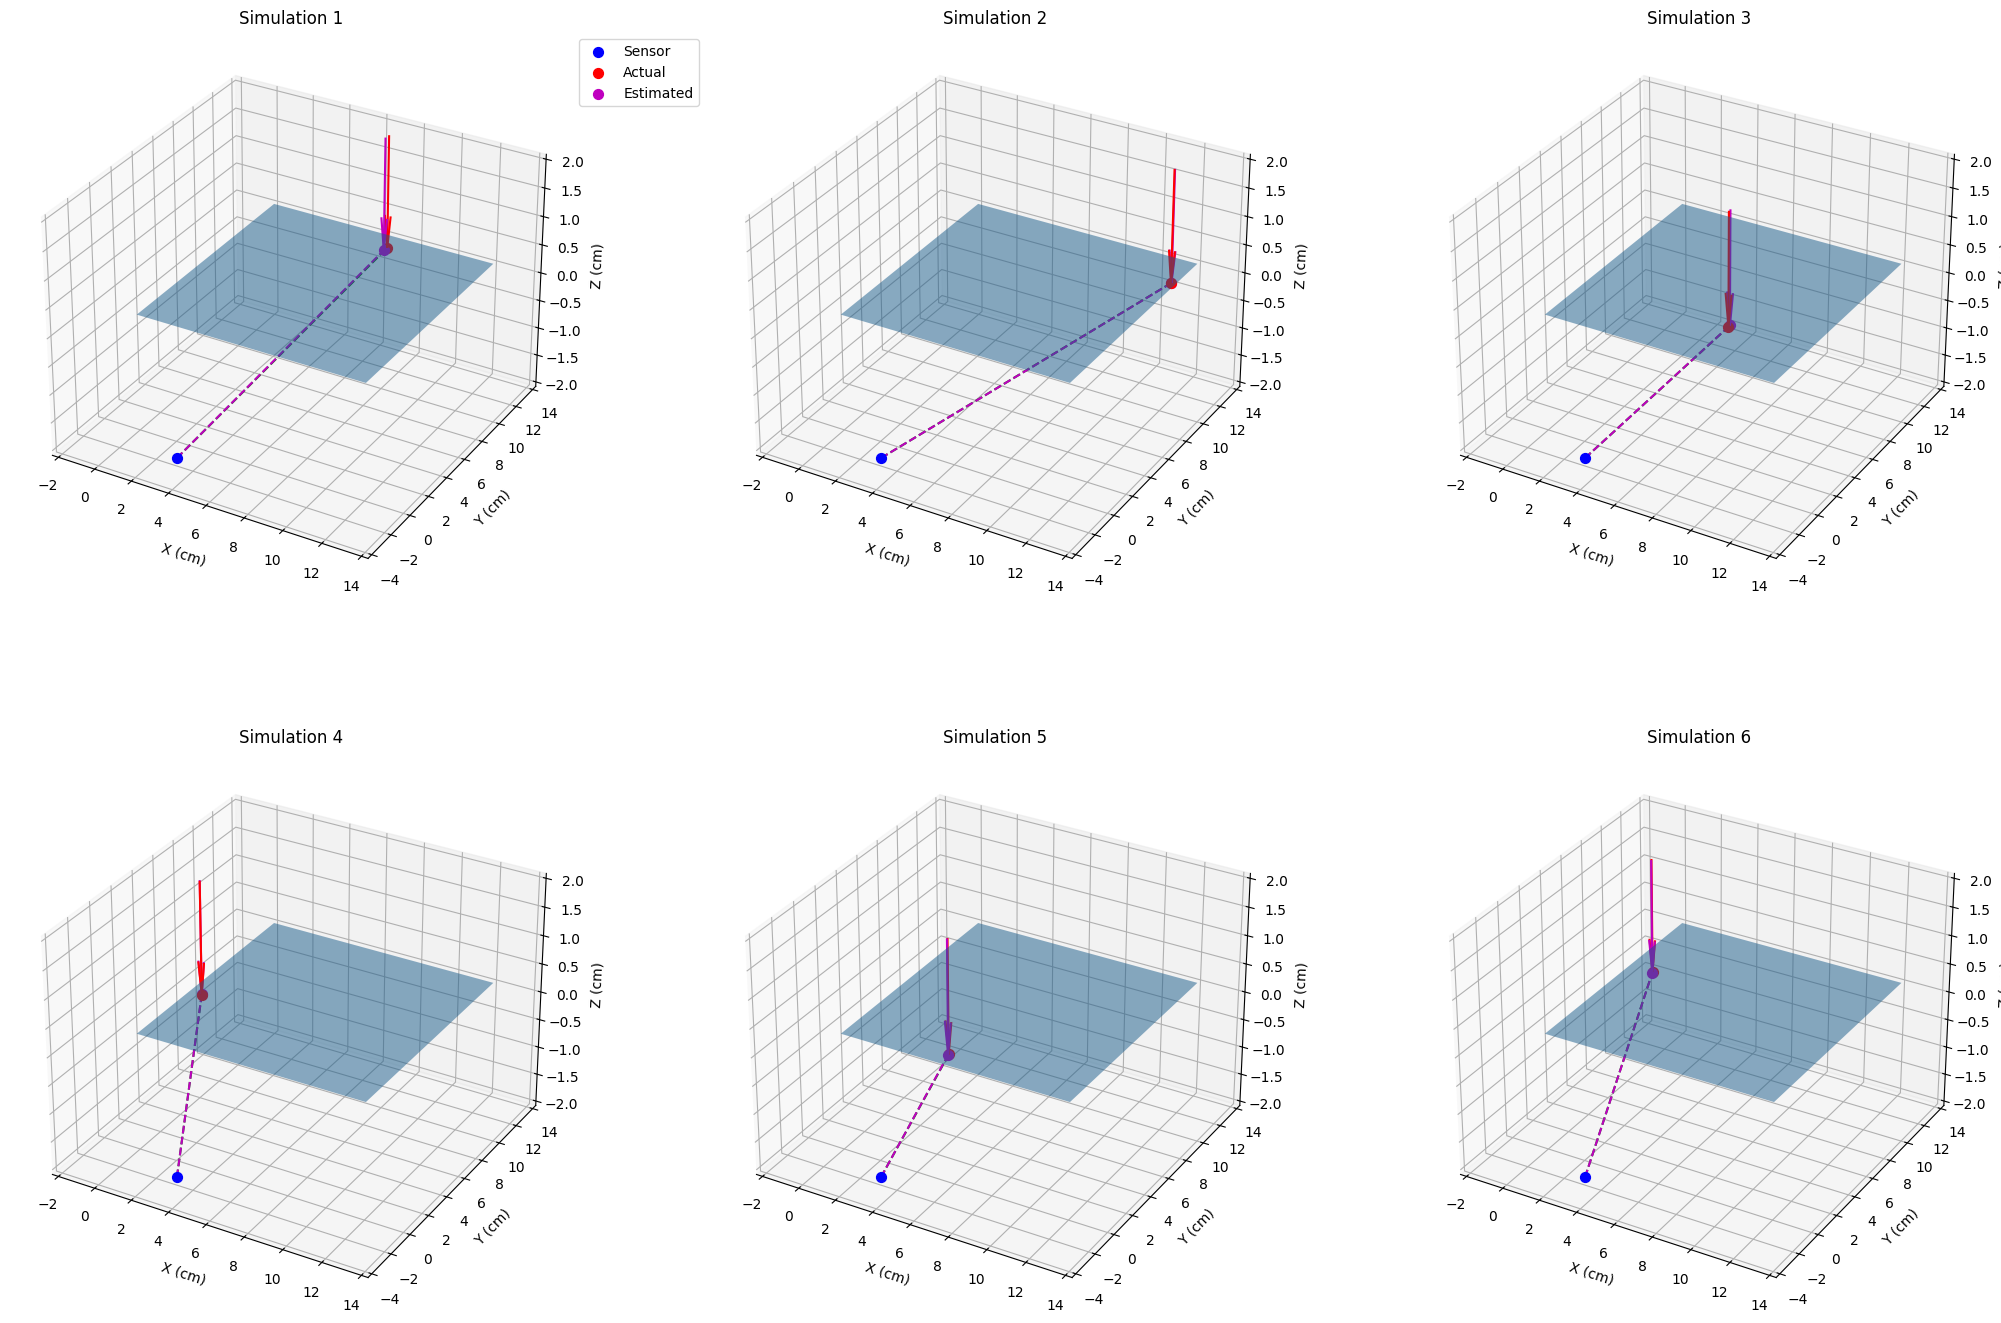

In [6]:
fig = plt.figure(figsize=(20, 15))

for i, sim in enumerate(simulations, 1):
    ax = fig.add_subplot(2, 3, i, projection='3d')
    force, actual_point, estimated_point = sim

    # Plot pad
    xx, yy = np.meshgrid([0.0, grid_size[0]], [0.0, grid_size[1]])
    ax.plot_surface(xx, yy, np.zeros_like(xx), alpha=0.5)

    # Plot force vector
    ax.quiver(actual_point[0], actual_point[1], 2.0, 0.0, 0.0, force[2],
                color='r', length=2.0, normalize=True, arrow_length_ratio=0.3)
    
    ax.quiver(estimated_point[0], estimated_point[1], 2.0, 0.0, 0.0, force[2],
                color='m', length=2.0, normalize=True, arrow_length_ratio=0.3)

    # Plot sensor location
    ax.scatter(*sensor.position, color='b', s=50, label='Sensor')

    # Plot actual and estimated points
    ax.scatter(actual_point[0], actual_point[1], 0.0, color='r', s=50, label='Actual')
    ax.scatter(estimated_point[0], estimated_point[1], 0.0, color='m', s=50, label='Estimated')

    # Plot lines from sensor to actual and estimated points
    ax.plot([sensor.position[0], actual_point[0]],
            [sensor.position[1], actual_point[1]],
            [sensor.position[2], 0.0], 'g--')
    ax.plot([sensor.position[0], estimated_point[0]],
            [sensor.position[1], estimated_point[1]],
            [sensor.position[2], 0.0], 'm--')

    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_zlabel('Z (cm)')
    ax.set_title(f'Simulation {i}')

    ax.set_xlim(- 2.0,  grid_size[0]+ 2.0)
    ax.set_ylim(-4.0,  grid_size[1])
    ax.set_zlim(-2.0, 2.0)

    if i == 1:  # Only add legend to the first subplot
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [7]:
def generate_grid_points(grid_size=(12, 14)):
    x = np.linspace(0.5, grid_size[0]- 0.5, grid_size[0])
    y = np.linspace(0.5, grid_size[1] - 0.5, grid_size[1])
    xx, yy = np.meshgrid(x, y)
    return np.column_stack((xx.ravel(), yy.ravel(), np.zeros(xx.size)))

def generate_force_cone(num_forces=5, max_angle=np.pi/4):

    phi = np.random.uniform(0, 2*np.pi, num_forces)
    theta = np.random.uniform(0, max_angle, num_forces)

    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = -np.cos(theta)  # Negative because we want forces pointing downward
    
    forces = np.vstack((x, y, z))
    magnitudes = np.random.uniform(5, 15, num_forces).reshape(1, num_forces)
    forces *= magnitudes
    return forces.T  # Return shape (num_forces, 3)

def generate_forces_for_grid(grid_points, num_forces_per_point=5):
    return np.array([generate_force_cone(num_forces_per_point) for _ in range(len(grid_points))])

In [8]:
num_forces_per_point = 3
grid_points = generate_grid_points(grid_size)
actual_forces = generate_forces_for_grid(grid_points, num_forces_per_point)


In [9]:
estimated_forces = []
estimated_positions_pinv = []
estimated_positions_constrained = []
errors_pinv = []
errors_constrained = []

# Estimate forces and positions
for point, forces in zip(grid_points, actual_forces):
    point_estimated_forces = []
    point_estimated_positions_pinv = []
    point_estimated_positions_constrained = []
    point_errors_pinv = []
    point_errors_constrained = []
    for force in forces:
        measurement = sensor.measure(force, point)
        estimated_force = measurement[:3]
        estimated_position_pinv = sensor.estimate_contact_point_pinv(measurement, use_plane_constraint=False)
        estimated_position_constrained = sensor.estimate_contact_point_pinv(measurement)
        error_pinv = np.linalg.norm(point - estimated_position_pinv)
        error_constrained = np.linalg.norm(point - estimated_position_constrained)
        point_estimated_forces.append(estimated_force)
        point_estimated_positions_pinv.append(estimated_position_pinv)
        point_estimated_positions_constrained.append(estimated_position_constrained)
        point_errors_pinv.append(error_pinv)
        point_errors_constrained.append(error_constrained)
    estimated_forces.append(point_estimated_forces)
    estimated_positions_pinv.append(point_estimated_positions_pinv)
    estimated_positions_constrained.append(point_estimated_positions_constrained)
    errors_pinv.append(point_errors_pinv)
    errors_constrained.append(point_errors_constrained)

estimated_forces = np.array(estimated_forces)
estimated_positions_pinv = np.array(estimated_positions_pinv)
estimated_positions_constrained = np.array(estimated_positions_constrained)
errors_pinv = np.array(errors_pinv)
errors_constrained = np.array(errors_constrained) 

# For pinv method
mean_error_pinv = np.mean(errors_pinv)
std_error_pinv = np.std(errors_pinv)
max_error_pinv = np.max(errors_pinv)

# For constrained method
mean_error_constrained = np.mean(errors_constrained)
std_error_constrained = np.std(errors_constrained)
max_error_constrained = np.max(errors_constrained)

# Print results
print(f"Pinv Method:")
print(f"Mean Error: {mean_error_pinv:.4f}")
print(f"Std Error: {std_error_pinv:.4f}")
print(f"Max Error: {max_error_pinv:.4f}")
print(f"\nConstrained Method:")
print(f"Mean Error: {mean_error_constrained:.4f}")
print(f"Std Error: {std_error_constrained:.4f}")
print(f"Max Error: {max_error_constrained:.4f}")

Pinv Method:
Mean Error: 3.5199
Std Error: 2.9633
Max Error: 13.5865

Constrained Method:
Mean Error: 0.1579
Std Error: 0.1212
Max Error: 0.6988


In [ ]:
def plot_forces_and_positions_3d(ax, grid_points, actual_forces, estimated_forces, estimated_positions, grid_size=(12, 14), title=""):
    # Plot the grid surface
    xx, yy = np.meshgrid(np.linspace(0, grid_size[0], grid_size[0]+1),
                         np.linspace(0, grid_size[1], grid_size[1]+1))
    ax.plot_surface(xx, yy, np.zeros_like(xx), alpha=0.3, color='gray')

    # Plot actual forces as red arrows
    for point, forces in zip(grid_points, actual_forces):
        for force in forces:
            ax.quiver(point[0], point[1], point[2], force[0], force[1], force[2], 
                      color='r', length=0.5, normalize=True, arrow_length_ratio=0.3, alpha=0.5)

    # Plot estimated forces as blue arrows
    for point, forces in zip(estimated_positions, estimated_forces):
        for pos, force in zip(point, forces):
            ax.quiver(pos[0], pos[1], pos[2], force[0], force[1], force[2], 
                      color='b', length=0.5, normalize=True, arrow_length_ratio=0.3, alpha=0.5)

    # Plot actual grid points
    ax.scatter(grid_points[:, 0], grid_points[:, 1], grid_points[:, 2], 
               color='green', s=20, label='Actual Points')

    # Plot estimated positions
    estimated_positions_flat = estimated_positions.reshape(-1, 3)
    ax.scatter(estimated_positions_flat[:, 0], estimated_positions_flat[:, 1], estimated_positions_flat[:, 2], 
               color='orange', s=20, label='Estimated Points', alpha=0.5)

    # Set labels and title
    ax.set_xlabel('X (cm)', fontsize=24, labelpad=15)
    ax.set_ylabel('Y (cm)', fontsize=24, labelpad=15)
    ax.set_zlabel('Z (cm)', fontsize=24)
    plt.title(title, fontsize=30)
    # Increase tick label size
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='z', labelsize=20)
    # Set axis limits
    ax.set_xlim(0, grid_size[0])
    ax.set_ylim(0, grid_size[1])
    ax.set_zlim(-5, 5)  # Adjust as needed
    ax.invert_xaxis()

    # Add legend
    actual_arrow_proxy = plt.Line2D([0], [0], linestyle="none", c='r', marker='^')
    estimated_arrow_proxy = plt.Line2D([0], [0], linestyle="none", c='b', marker='^')
    actual_point_proxy = plt.Line2D([0], [0], linestyle="none", c='green', marker='o')
    estimated_point_proxy = plt.Line2D([0], [0], linestyle="none", c='orange', marker='o')
    # plt.legend([actual_arrow_proxy, estimated_arrow_proxy, actual_point_proxy, estimated_point_proxy], 
    #            ["Actual Forces", "Estimated Forces", "Actual Points", "Estimated Points"], numpoints=1, fontsize=20)

    ax.grid(True)

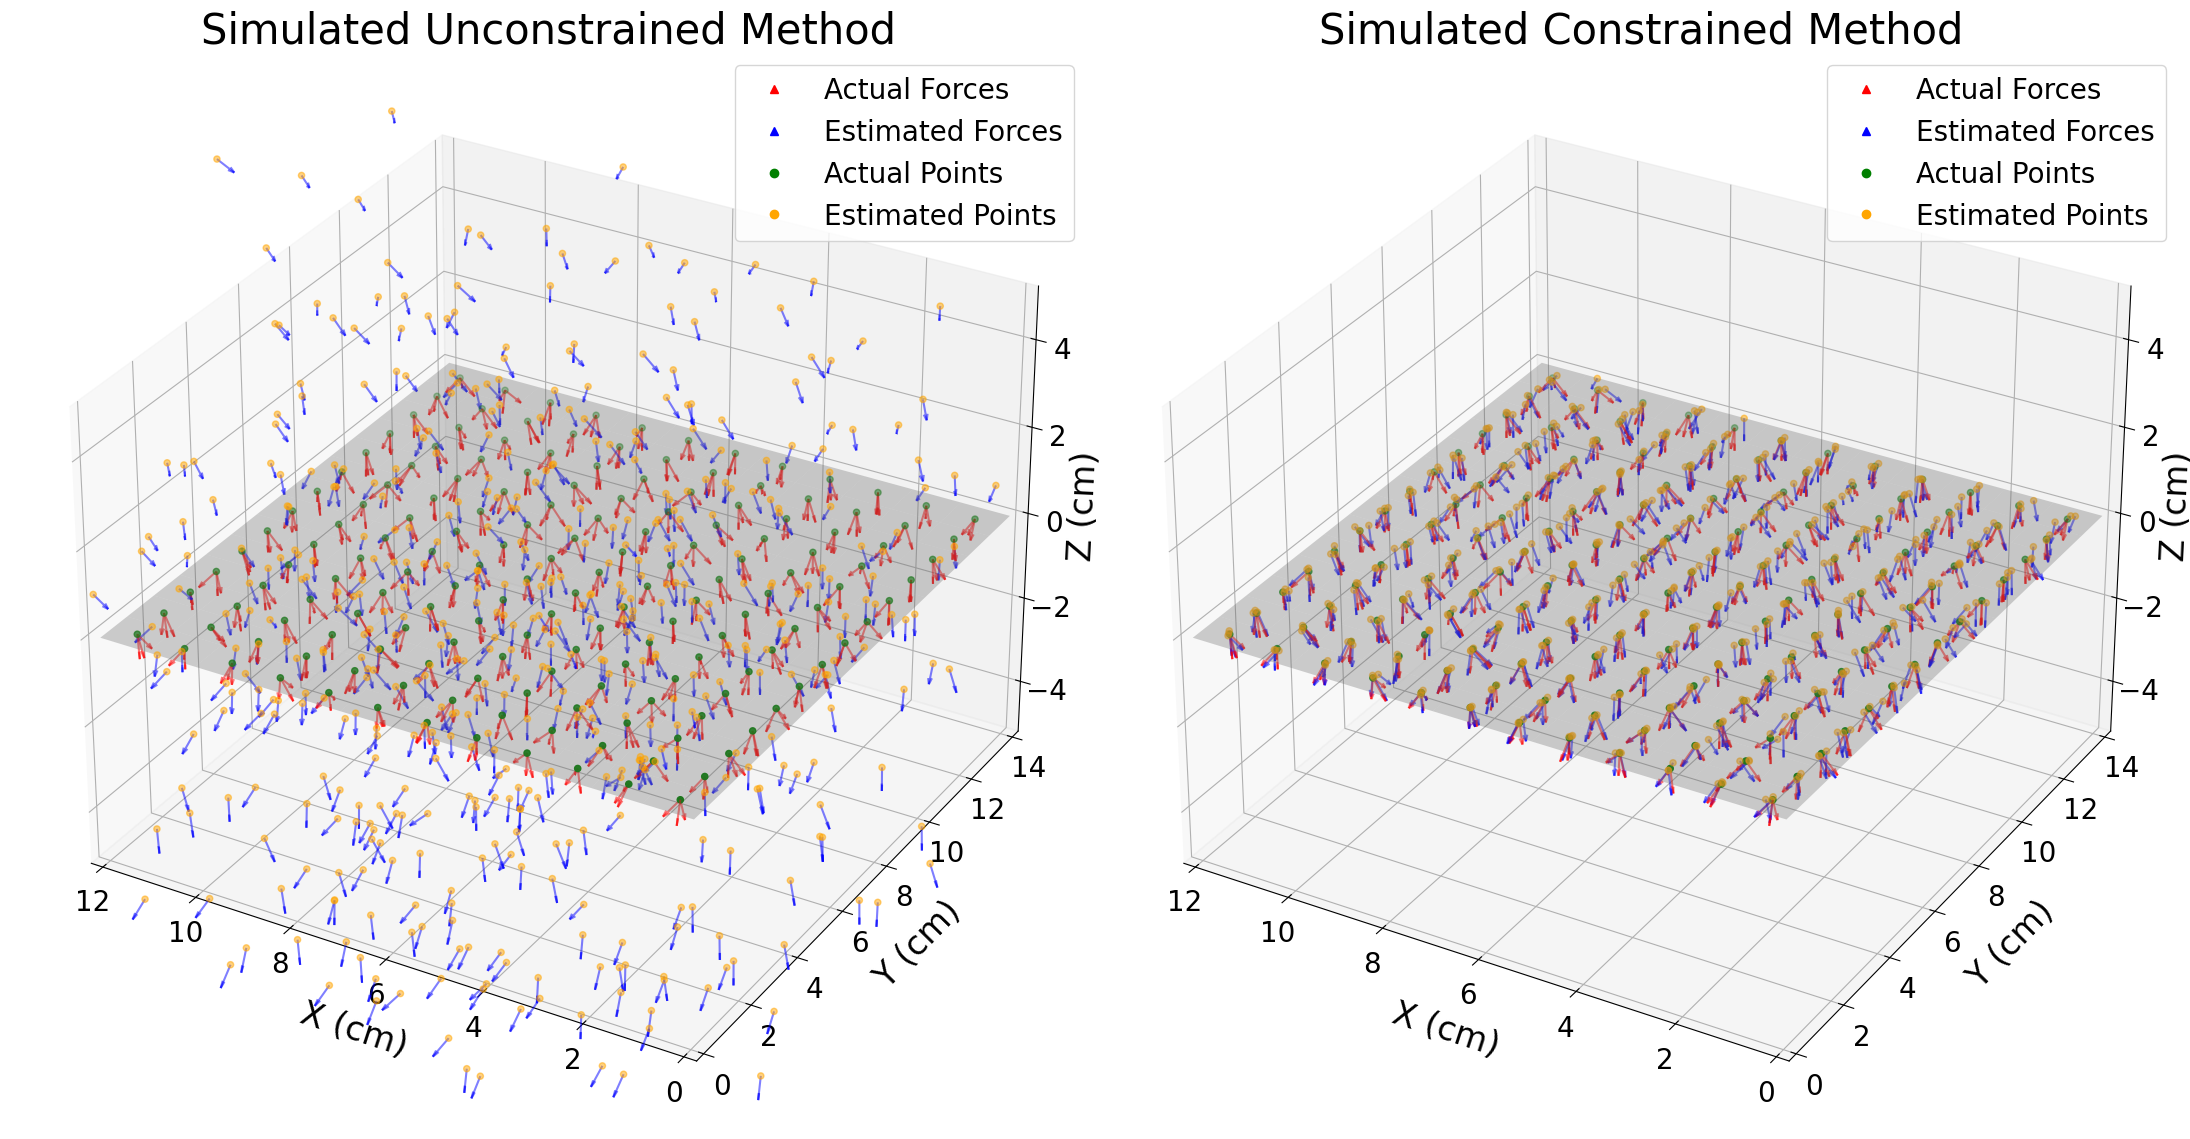

In [79]:
fig = plt.figure(figsize=(22, 12))
    
# Pinv method plot
ax1 = fig.add_subplot(121, projection='3d')
plot_forces_and_positions_3d(ax1, grid_points, actual_forces, estimated_forces, estimated_positions_pinv, 
                    grid_size, "Simulated Unconstrained Method")

# Constrained method plot
ax2 = fig.add_subplot(122, projection='3d')
plot_forces_and_positions_3d(ax2, grid_points, actual_forces, estimated_forces, estimated_positions_constrained, 
                    grid_size, "Simulated Constrained Method")

plt.tight_layout()

fig.savefig('../../img/sim_comparison_unconstrained_constrained.png', dpi=600, bbox_inches='tight', format='png')

plt.show()

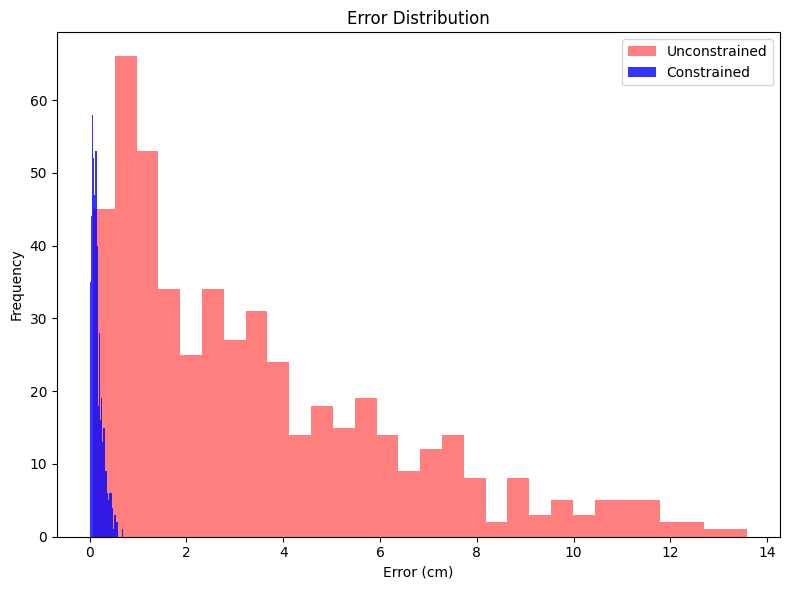

In [46]:
# Create histograms
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histograms
ax.hist(errors_pinv.flatten(), bins=30, alpha=0.5, label='Unconstrained', color='red')
ax.hist(errors_constrained.flatten(), bins=30, alpha=0.8, label='Constrained', color='blue')

# Add labels and title
ax.set_xlabel('Error (cm)')
ax.set_ylabel('Frequency')
ax.set_title('Error Distribution')
ax.legend()

plt.tight_layout()
plt.show()

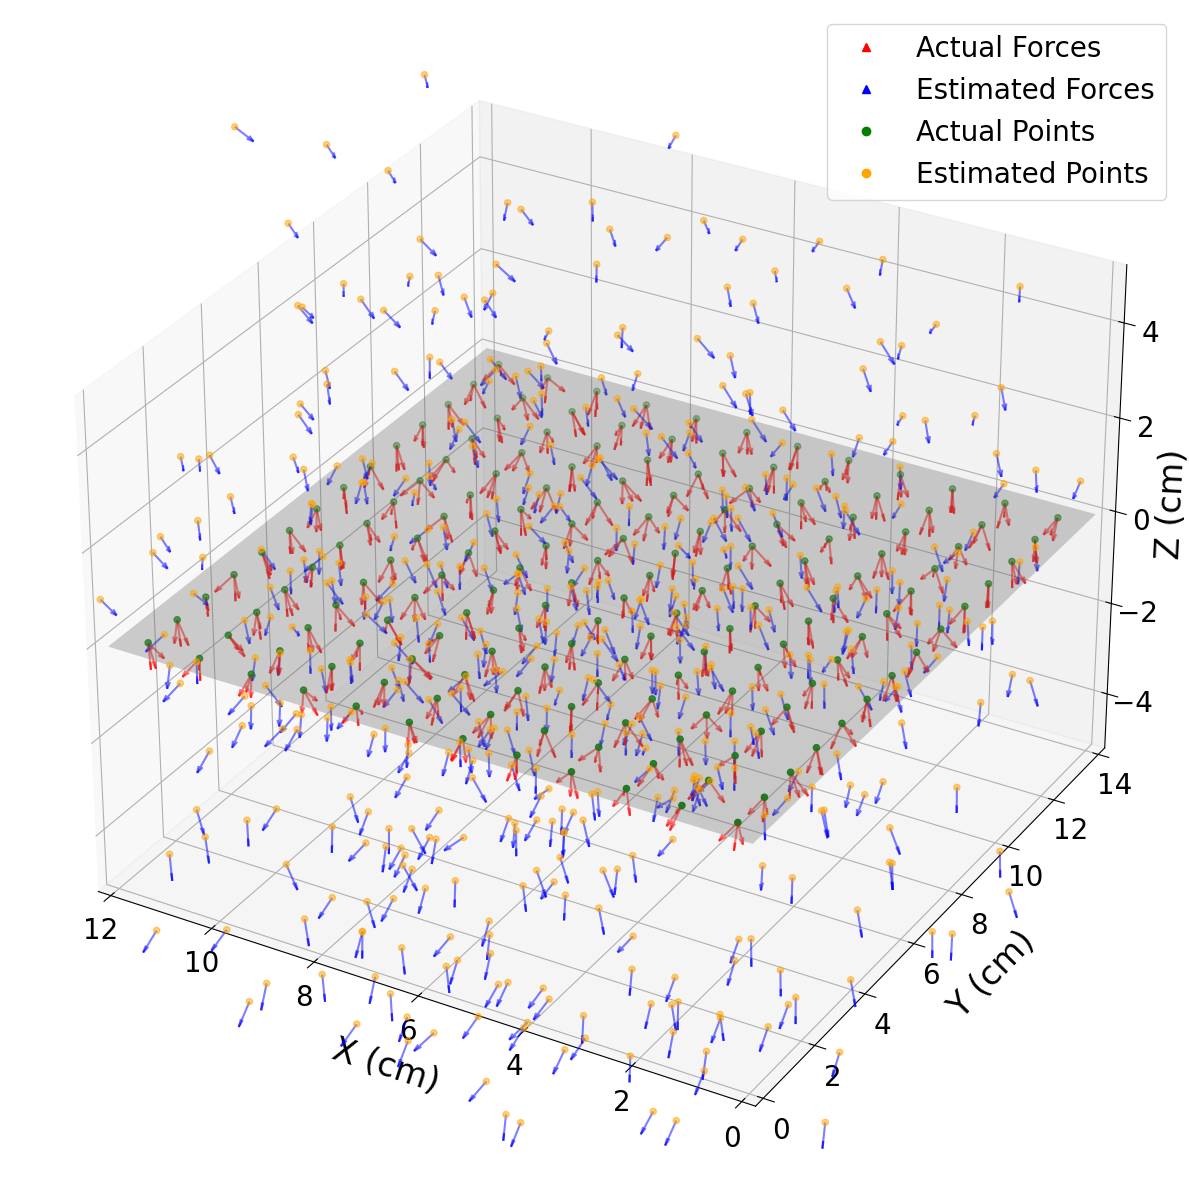

In [84]:
fig = plt.figure(figsize=(12, 12))

# Pinv method plot
ax1 = fig.add_subplot(111, projection='3d')
plot_forces_and_positions_3d(ax1, grid_points, actual_forces, estimated_forces, estimated_positions_pinv, 
                   grid_size)

# Constrained method plot
# ax2 = fig.add_subplot(111, projection='3d')
# plot_forces_and_positions_3d(ax2, grid_points, actual_forces, estimated_forces, estimated_positions_constrained, 
#                    grid_size)

plt.tight_layout()
fig.savefig('../../img/projection1.png', dpi=600, bbox_inches='tight', format='png')

plt.show()

In [84]:
def plot_error_3d(ax, errors, grid_size=(12, 14), title="None"):
    # Calculate average error for each grid point
    avg_errors = np.mean(errors, axis=1)
    # Create a meshgrid for the surface plot
    x = np.linspace(0.5, grid_size[0] - 0.5, grid_size[0])
    y = np.linspace(0.5, grid_size[1] - 0.5, grid_size[1])
    X, Y = np.meshgrid(x, y)

    # Reshape the average errors to match the grid
    Z = avg_errors.reshape(grid_size[1], grid_size[0])

    # Create the surface plot
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)

    # Customize the plot
    # Set labels and title
    ax.set_xlabel('X (cm)', fontsize=24, labelpad=10)
    ax.set_ylabel('Y (cm)', fontsize=24, labelpad=10)
    ax.set_zlabel('Error (cm)', fontsize=24, labelpad=10)
    # Increase tick label size
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='z', labelsize=20)
    
    ax.set_title(title, fontsize=30)

    # Add a color bar
    fig = plt.gcf()
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    cbar.ax.tick_params(labelsize=20)  # Increase tick label size

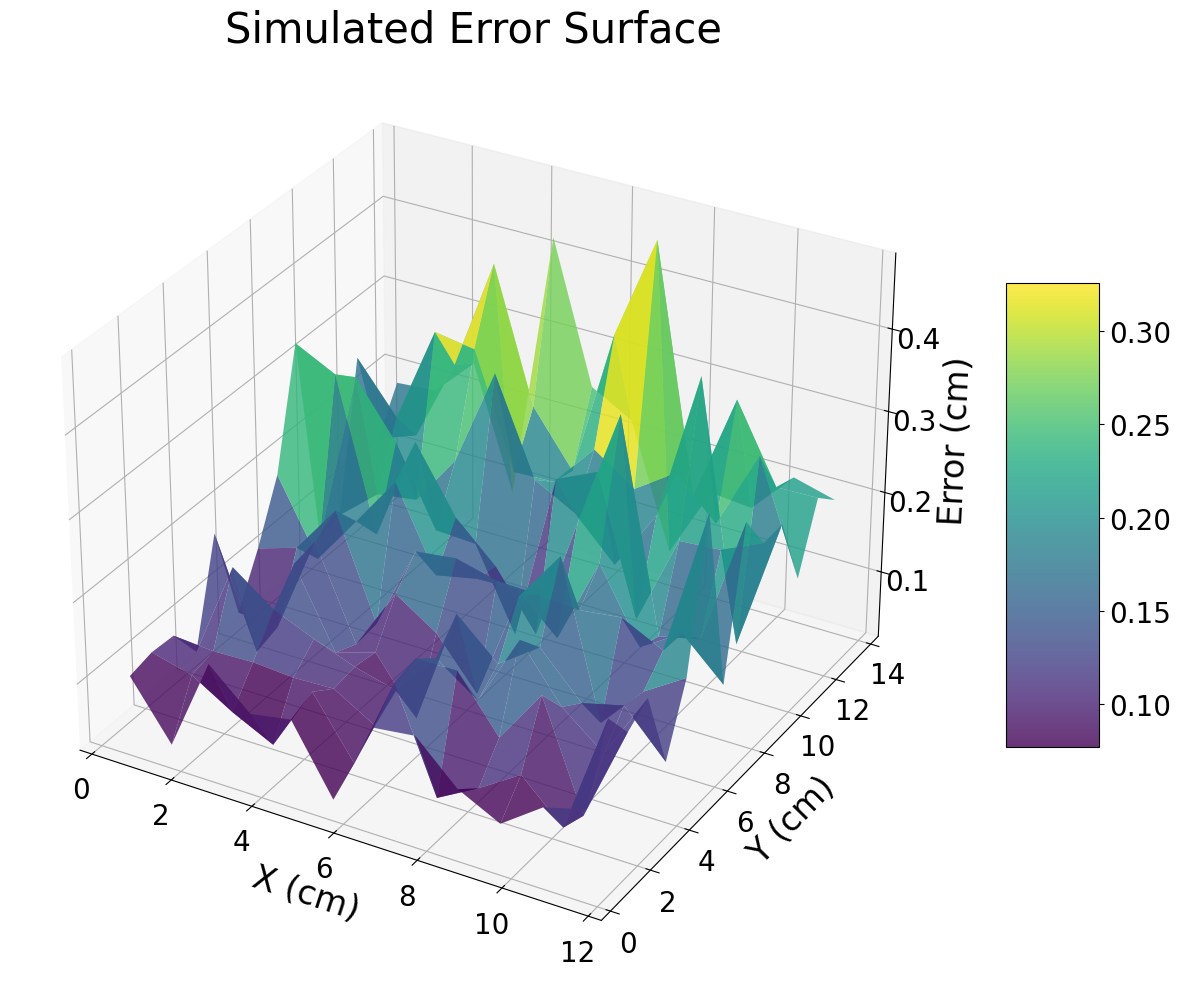

In [ ]:
fig = plt.figure(figsize=(14, 10))
    
# Pinv method error plot
ax1 = fig.add_subplot(111, projection='3d')
plot_error_3d(ax1, errors_constrained, grid_size, "Simulated Error Surface")

# Constrained method error plot
# ax2 = fig.add_subplot(122, projection='3d')
# plot_error_3d(ax2, errors_constrained, grid_size, "Constrained Method Error")

plt.tight_layout()

#fig.savefig('../../img/sim_error_heatmap.png', dpi=600, bbox_inches='tight', format='png')

plt.show()

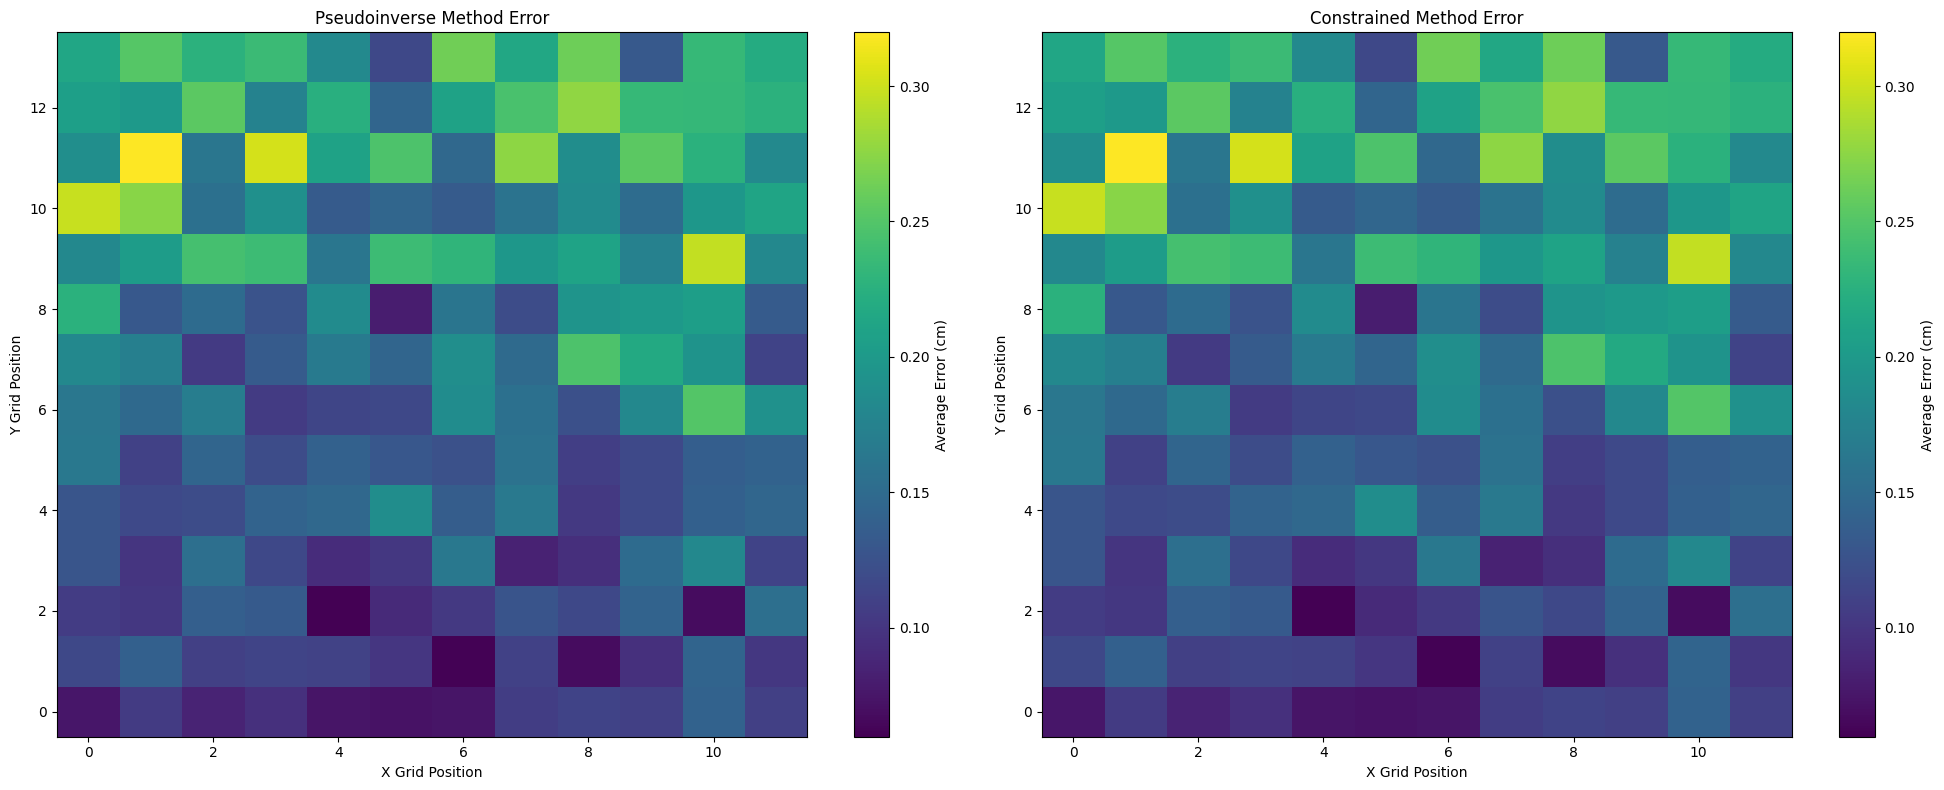

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Calculate average errors
avg_errors_pinv = np.mean(errors_pinv, axis=1).reshape(grid_size[1], grid_size[0])
avg_errors_constrained = np.mean(errors_constrained, axis=1).reshape(grid_size[1], grid_size[0])

# Create heatmaps
im1 = ax1.imshow(avg_errors_pinv, cmap='viridis', origin='lower', aspect='auto')
im2 = ax2.imshow(avg_errors_constrained, cmap='viridis', origin='lower', aspect='auto')

# Add color bars
fig.colorbar(im1, ax=ax1, label='Average Error (cm)')
fig.colorbar(im2, ax=ax2, label='Average Error (cm)')

# Set titles and labels
ax1.set_title('Pseudoinverse Method Error')
ax2.set_title('Constrained Method Error')
for ax in (ax1, ax2):
    ax.set_xlabel('X Grid Position')
    ax.set_ylabel('Y Grid Position')

plt.tight_layout()
plt.show()

In [30]:
pinv_times = []
constrained_times = []
num_runs = 10

for point, forces in zip(grid_points, actual_forces):
    for force in forces:
        measurement = sensor.measure(force, point)
        
        _, pinv_time = sensor.estimate_contact_point_pinv_timed(measurement)
        _, constrained_time = sensor.estimate_contact_point_constrained_timed(measurement)
        
        pinv_times.append(pinv_time)
        constrained_times.append(constrained_time)

avg_pinv_time = np.mean(pinv_times)
avg_constrained_time = np.mean(constrained_times)
std_pinv_time = np.std(pinv_times)
std_constrained_time = np.std(constrained_times)

print("\nOne measurement timing")

print(f"Average solving time for pinv method: {avg_pinv_time:.6f} ± {std_pinv_time:.6f} seconds")
print(f"Average solving time for constrained method: {avg_constrained_time:.6f} ± {std_constrained_time:.6f} seconds")

pinv_times = []
constrained_times = []

for _ in range(num_runs):
    # Timing for pinv method
    start_time = time.time()
    for point, forces in zip(grid_points, actual_forces):
        for force in forces:
            measurement = sensor.measure(force, point)
            _ = sensor.estimate_contact_point_pinv(measurement)
    pinv_times.append(time.time() - start_time)

    # Timing for constrained method
    start_time = time.time()
    for point, forces in zip(grid_points, actual_forces):
        for force in forces:
            measurement = sensor.measure(force, point)
            _ = sensor.estimate_contact_point_constrained(measurement)
    constrained_times.append(time.time() - start_time)

avg_pinv_time = np.mean(pinv_times)
avg_constrained_time = np.mean(constrained_times)
std_pinv_time = np.std(pinv_times)
std_constrained_time = np.std(constrained_times)

print("\nEntire grid Timing")
print(f"Average solving time for pinv method: {avg_pinv_time:.6f} ± {std_pinv_time:.6f} seconds")
print(f"Average solving time for constrained method: {avg_constrained_time:.6f} ± {std_constrained_time:.6f} seconds")

# Calculate the number of estimations
num_estimations = sum(len(forces) for forces in actual_forces)
print(f"\nTotal number of estimations per run: {num_estimations}")


One measurement timing
Average solving time for pinv method: 0.000050 ± 0.000015 seconds
Average solving time for constrained method: 0.000038 ± 0.000013 seconds

Entire grid Timing
Average solving time for pinv method: 0.090919 ± 0.029610 seconds
Average solving time for constrained method: 0.073486 ± 0.022978 seconds

Total number of estimations per run: 1680


In [31]:
num_forces = 10
singularity_map = np.zeros(grid_points.shape[0])
for i, point in enumerate(grid_points):
    forces = generate_force_cone(num_forces)
    for force in forces:
        is_singular, singularities = sensor.check_singularity(force, point)
        if  is_singular:
            print("Singularities detected:", singularities)
            singularity_map[i] += 1
singularity_map /= num_forces  # Normalize to get probability

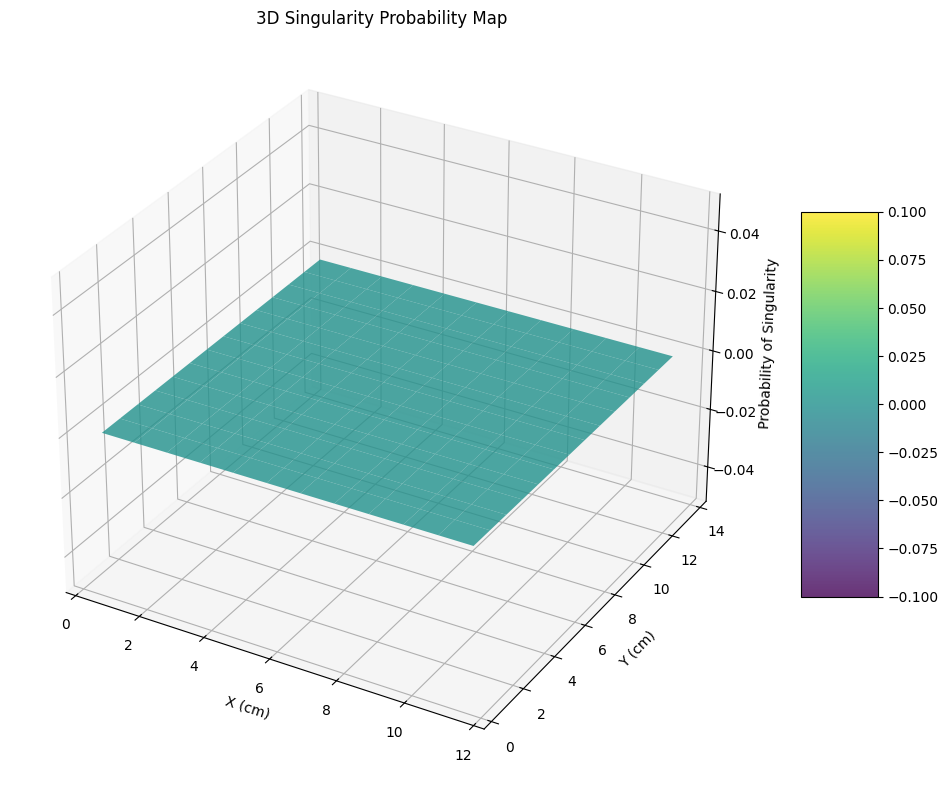

In [32]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0.5, grid_size[0] - 0.5, grid_size[0])
y = np.linspace(0.5, grid_size[1] - 0.5, grid_size[1])
X, Y = np.meshgrid(x, y)
Z = singularity_map.reshape(grid_size[1], grid_size[0])

surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)

ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Probability of Singularity')
ax.set_title('3D Singularity Probability Map')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()